In [1]:
import sys
import os

project_path = r"C:\Users\jjmcc\OneDrive\Documents\Thesis Interim\ITGC-interim"
sys.path.append(project_path)

print("Project path added.")

Project path added.


In [2]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap
import os


d:\Users\jjmcc\anaconda3\envs\ITGC-interim\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
embed_path = r"E:/ProcessedMRI/mri_embeds.pbz2"

embeds_dict = joblib.load(embed_path)
print("Loaded embeddings:", len(embeds_dict), "samples")


Loaded embeddings: 40 samples


In [4]:
# embeds_dict: { 'A1K2P5_slice0': vector, ... }

keys = list(embeds_dict.keys())
X = np.array([embeds_dict[k] for k in keys])

print("Embedding matrix:", X.shape)


Embedding matrix: (40, 512)


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_scaled)
print("UMAP reduced shape:", X_umap.shape)


d:\Users\jjmcc\anaconda3\envs\ITGC-interim\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP reduced shape: (40, 2)


In [7]:
n_clusters = 5    # Try 5 to start
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_umap)


d:\Users\jjmcc\anaconda3\envs\ITGC-interim\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
d:\Users\jjmcc\anaconda3\envs\ITGC-interim\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


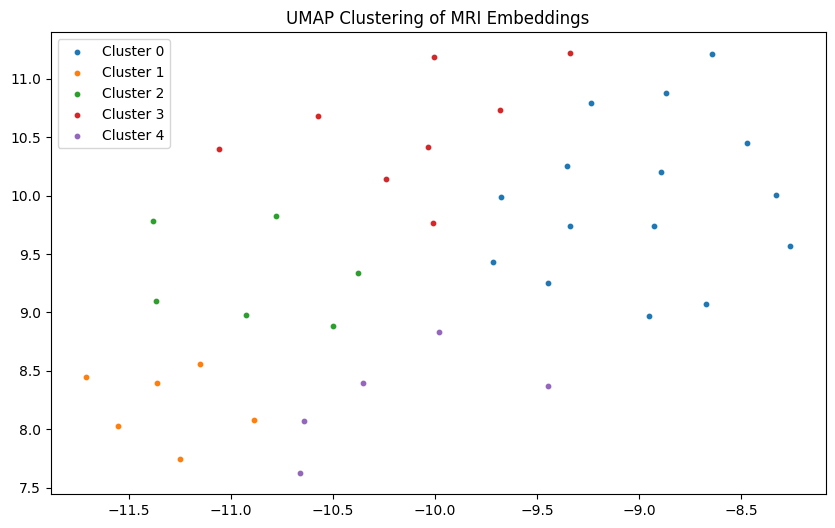

In [8]:
plt.figure(figsize=(10, 6))
for c in range(n_clusters):
    idx = clusters == c
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], s=10, label=f"Cluster {c}")

plt.title("UMAP Clustering of MRI Embeddings")
plt.legend()
plt.show()


In [9]:
cluster_contents = {c: [] for c in range(n_clusters)}

for key, cluster_id in zip(keys, clusters):
    cluster_contents[cluster_id].append(key)
    
print(cluster_contents)


{0: ['slice_03_ES.png', 'slice_04_ED.png', 'slice_04_ES.png', 'slice_05_ED.png', 'slice_06_ED.png', 'slice_07_ED.png', 'slice_07_ES.png', 'slice_09_ED.png', 'slice_09_ES.png', 'slice_10_ED.png', 'slice_10_ES.png', 'slice_11_ED.png', 'slice_16_ES.png', 'slice_17_ES.png', 'slice_19_ES.png'], 1: ['slice_12_ES.png', 'slice_13_ES.png', 'slice_14_ED.png', 'slice_14_ES.png', 'slice_15_ED.png', 'slice_15_ES.png'], 2: ['slice_00_ES.png', 'slice_01_ED.png', 'slice_01_ES.png', 'slice_02_ES.png', 'slice_17_ED.png', 'slice_19_ED.png'], 3: ['slice_03_ED.png', 'slice_05_ES.png', 'slice_06_ES.png', 'slice_08_ED.png', 'slice_08_ES.png', 'slice_11_ES.png', 'slice_18_ED.png', 'slice_18_ES.png'], 4: ['slice_00_ED.png', 'slice_02_ED.png', 'slice_12_ED.png', 'slice_13_ED.png', 'slice_16_ED.png']}


In [10]:
import os

root = r"E:\ProcessedMRI"   # Or your raw dataset folder

# Find all PNG files
png_files = []
for path, folders, files in os.walk(root):
    for f in files:
        if f.endswith(".png"):
            png_files.append(os.path.join(path, f))

print("Found PNG files:", len(png_files))
print("\nExample:", png_files[:5])


Found PNG files: 3242

Example: ['E:\\ProcessedMRI\\G8K0M3\\slice_00_ED.png', 'E:\\ProcessedMRI\\G8K0M3\\slice_00_ES.png', 'E:\\ProcessedMRI\\G8K0M3\\slice_01_ED.png', 'E:\\ProcessedMRI\\G8K0M3\\slice_01_ES.png', 'E:\\ProcessedMRI\\G8K0M3\\slice_02_ED.png']


Example key: slice_03_ES.png
Resolved path: E:\ProcessedMRI\G8K0M3\slice_03_ES.png


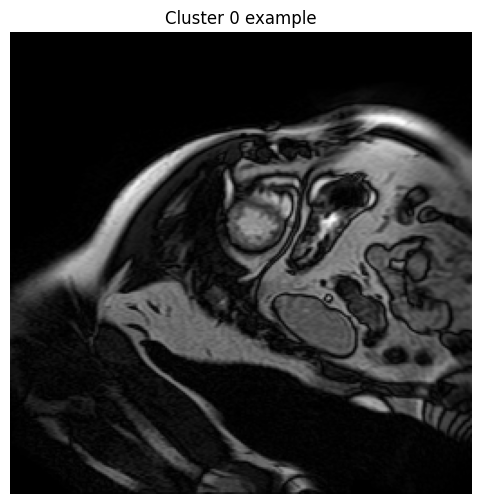

In [11]:
import cv2
import matplotlib.pyplot as plt
import os

# Point this to ProcessedMRI since PNGs live there
PNG_ROOT = r"E:\ProcessedMRI"

def find_png_path(file_name):
    """
    Search for a PNG filename inside ProcessedMRI and all subfolders.
    """
    for path, dirs, files in os.walk(PNG_ROOT):
        if file_name in files:
            return os.path.join(path, file_name)
    return None

def show_example(cluster_id):
    """
    Visualize the first PNG image belonging to a given cluster.
    """
    cluster_keys = [k for k, c in zip(keys, clusters) if c == cluster_id]

    if not cluster_keys:
        print(f"No images found for cluster {cluster_id}")
        return

    key = cluster_keys[0]
    print("Example key:", key)

    img_path = find_png_path(key)
    print("Resolved path:", img_path)

    if img_path is None:
        print("❌ PNG not found in ProcessedMRI!")
        return

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(f"Cluster {cluster_id} example")
    plt.axis("off")
    plt.show()
# Show example for cluster 0
show_example(0)



In [12]:
import os

# The folder where ALL PNG slices live
data_root = r"E:/ProcessedMRI"

# Create a mapping from embedding key → absolute file path
key_to_path = {}

for root, dirs, files in os.walk(data_root):
    for f in files:
        if f.endswith(".png"):
            key_to_path[f] = os.path.join(root, f)

print("Mapped", len(key_to_path), "PNG files")


Mapped 40 PNG files



Showing example for cluster 0
Loading: E:/ProcessedMRI\L8M2U8\slice_03_ES.png


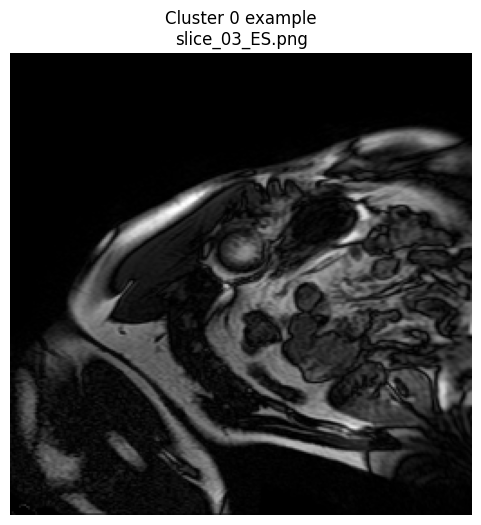


Showing example for cluster 1
Loading: E:/ProcessedMRI\L8M2U8\slice_12_ES.png


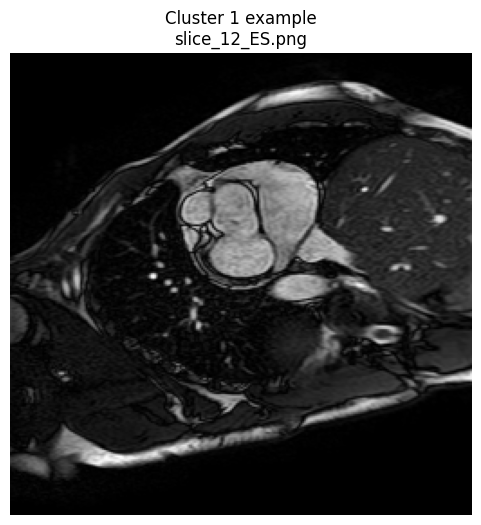


Showing example for cluster 2
Loading: E:/ProcessedMRI\L8M2U8\slice_00_ES.png


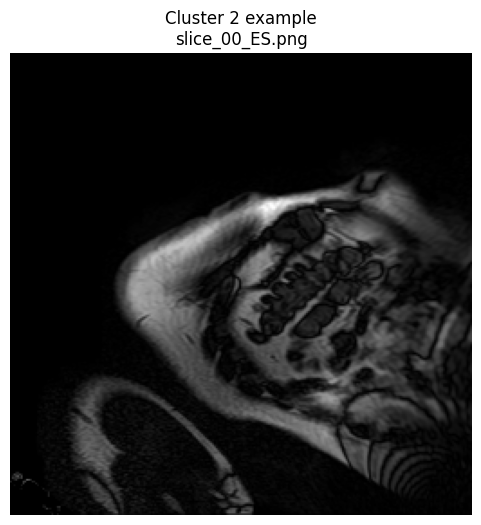


Showing example for cluster 3
Loading: E:/ProcessedMRI\L8M2U8\slice_03_ED.png


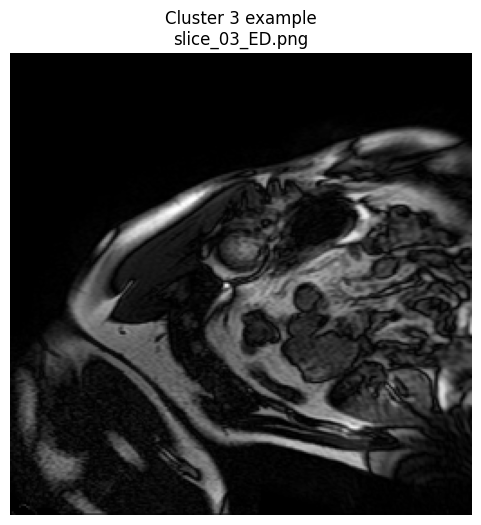


Showing example for cluster 4
Loading: E:/ProcessedMRI\L8M2U8\slice_00_ED.png


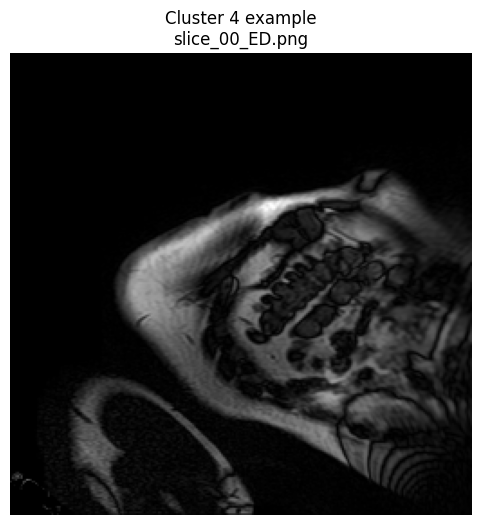

In [13]:
import cv2
import matplotlib.pyplot as plt

def show_example(c):
    print(f"\nShowing example for cluster {c}")

    # pick first key from this cluster
    key = cluster_contents[c][0]
    path = key_to_path[key]

    print("Loading:", path)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(f"Cluster {c} example\n{key}")
    plt.axis("off")
    plt.show()

for c in range(n_clusters):
    show_example(c)


In [14]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_clustering(X_features, labels):
    print("=== Clustering Quality Metrics ===")
    
    sil = silhouette_score(X_features, labels)
    print(f"Silhouette Score:           {sil:.4f}")


    return sil

In [15]:
print("IMAGE-ONLY CLUSTERING METRICS:")
evaluate_clustering(X_scaled, clusters)


IMAGE-ONLY CLUSTERING METRICS:
=== Clustering Quality Metrics ===
Silhouette Score:           -0.0077


-0.007684958167374134